# Проект MADE 2022

В данном ноутбуке результаты EDA для датасета DBLP-Citation-network V13 (https://www.aminer.cn/citation). Данный датасет выбран в рамках работы над учебным проектом (для решения задач topic modeling и рекомендаций)

In [1]:
import pandas as pd
from collections import Counter, defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.



# Read data

In [16]:
path = '../input/cndbv13/test1.json'
df = pd.read_json(path, lines=True, chunksize = 450000)
df = next(iter(df))
df.shape

(450000, 20)

In [17]:
# Где id статей и id, на кот цитируеются статьи? Можно посчитать индекс Хирша
df.head()

,_id,title,authors,venue,year,n_citation,page_start,page_end,lang,volume,issue,issn,isbn,doi,pdf,url,fos,references,keywords,abstract
0,53a7258520f7420be8b514a9,Semantic Wikipedia.,"[{'_id': '53f47915dabfaefedbbb728f', 'name': '...","{'_id': '53a7257a20f7420be8b50425', 'type': 0,...",2006.0,647.0,585,594,en,,,,,10.1145/1135777.1135863,None,"[http://doi.acm.org/10.1145/1135777.1135863, d...",NaN,NaN,NaN,NaN
1,53a725db20f7420be8b5bfc6,Deductive Algorithmic Knowledge.,[{'name': 'Riccardo Pucella'}],"{'_id': '53a725d920f7420be8b5b577', 'sid': 'co...",2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[http://rutcor.rutgers.edu/~amai/aimath04/Acce...,NaN,NaN,NaN,NaN
2,53a725db20f7420be8b5bff3,Improving Exact Algorithms for MAX-2-SAT.,"[{'name': 'Haiou Shen', '_id': '53f4469bdabfae...","{'_id': '53a725d920f7420be8b5b577', 'sid': 'co...",2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[http://rutcor.rutgers.edu/~amai/aimath04/Acce...,NaN,NaN,NaN,NaN
3,53a725db20f7420be8b5bffb,Learning via Finitely Many Queries.,[{'name': 'Andrew C. Lee'}],"{'_id': '53a725d920f7420be8b5b577', 'sid': 'co...",2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[http://rutcor.rutgers.edu/~amai/aimath04/Acce...,NaN,NaN,NaN,NaN
4,53a725db20f7420be8b5c00f,A Framework for Sequential Planning in Multi-A...,"[{'name': 'Piotr J. Gmytrasiewicz'}, {'name': ...","{'_id': '53a725d920f7420be8b5b577', 'sid': 'co...",2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[http://rutcor.rutgers.edu/~amai/aimath04/Acce...,NaN,NaN,NaN,NaN


A DOI will help your reader easily locate a document from your citation. Think of it like a Social Security number for the article you're citing — it will always refer to that article, and only that one. While a web address (URL) might change, the DOI will never change.

In [18]:
df.columns

Index(['_id', 'title', 'authors', 'venue', 'year', 'n_citation', 'page_start',
       'page_end', 'lang', 'volume', 'issue', 'issn', 'isbn', 'doi', 'pdf',
       'url', 'fos', 'references', 'keywords', 'abstract'],
      dtype='object')

In [19]:
# Оставим только необходимые для решения задачи поля
use_cols = ['_id', 'title', 'authors', 'venue', 'year', 'n_citation', 'lang', 'volume', 'issue', 'pdf', 'url', 'fos', 'references', 'keywords', 'abstract']

In [20]:
df = df[use_cols]

In [21]:
df.describe()

,year,n_citation
count,449998.000000,447207.000000
mean,2003.551489,38.134971
std,30.035306,323.650318
min,0.000000,0.000000
25%,2000.000000,1.000000
50%,2006.000000,6.000000
75%,2010.000000,23.000000
max,2300.000000,62923.000000


#### 1. Есть выбросы (скорее всего опечатка) - максимальный год статьи - 2300 - нужно убрать
#### 2. Значение mean для поля years - 2003
#### 3. Среднее кол-во цитирований - 38

# Statistics

## Дубликаты

In [22]:
df.shape

(450000, 15)

In [23]:
df.drop_duplicates(['_id'], keep='last').shape

(450000, 15)

#### Почему по _id не удаляются дубликаты ? Может, есть правки (если есть статьи с одним и тем же автором и названием)

In [24]:
df['authors'] = df['authors'].astype('str')

In [25]:
df.drop_duplicates(['title', 'authors'], keep='last').shape

(449805, 15)

In [26]:
df = df.drop_duplicates(['title', 'authors'], keep='last')

## Пропуски

In [27]:
# Количество ненулевых значений
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449805 entries, 0 to 449999
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   _id         449805 non-null  object 
 1   title       449770 non-null  object 
 2   authors     449805 non-null  object 
 3   venue       446028 non-null  object 
 4   year        449803 non-null  float64
 5   n_citation  447017 non-null  float64
 6   lang        449772 non-null  object 
 7   volume      444327 non-null  object 
 8   issue       442032 non-null  object 
 9   pdf         142491 non-null  object 
 10  url         442246 non-null  object 
 11  fos         414321 non-null  object 
 12  references  325729 non-null  object 
 13  keywords    449622 non-null  object 
 14  abstract    429999 non-null  object 
dtypes: float64(2), object(13)
memory usage: 54.9+ MB
None


In [28]:
notnull_values = (df.isna().sum()/450000) * 100
notnull_values = notnull_values.sort_values()
notnull_values

_id            0.000000
authors        0.000000
year           0.000444
lang           0.007333
title          0.007778
keywords       0.040667
n_citation     0.619556
venue          0.839333
volume         1.217333
url            1.679778
issue          1.727333
abstract       4.401333
fos            7.885333
references    27.572444
pdf           68.292000
dtype: float64

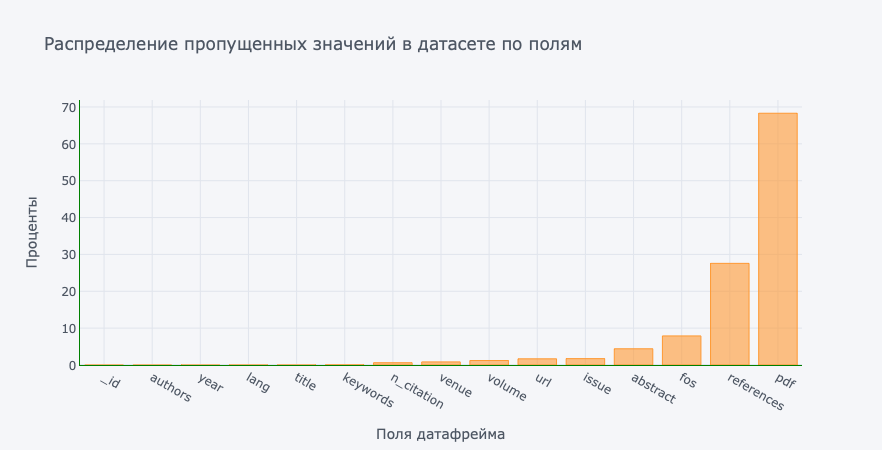

In [29]:
notnull_values.iplot(kind='bar',
                     xTitle='Поля датафрейма',
                     linecolor='green',
                     yTitle='Проценты',
                     title='Распределение пропущенных значений в датасете по полям')

#### Наибольшее кол-во пропусков в поле pdf (около 70%), поля _id и title пропусков не содержат, поле abstract, нужное для topic modeling содержит ~ 7% пропусков. Поле references содержит около 30% пропусков

## Статистика по годам

In [30]:
years = df[df['year'].notnull()].year

In [31]:
years = years.astype(int)
years.value_counts()

2011    32564
2009    31662
2012    31417
2013    31163
2010    30721
        ...  
1911        1
1934        1
1898        1
1874        1
2300        1
Name: year, Length: 119, dtype: int64

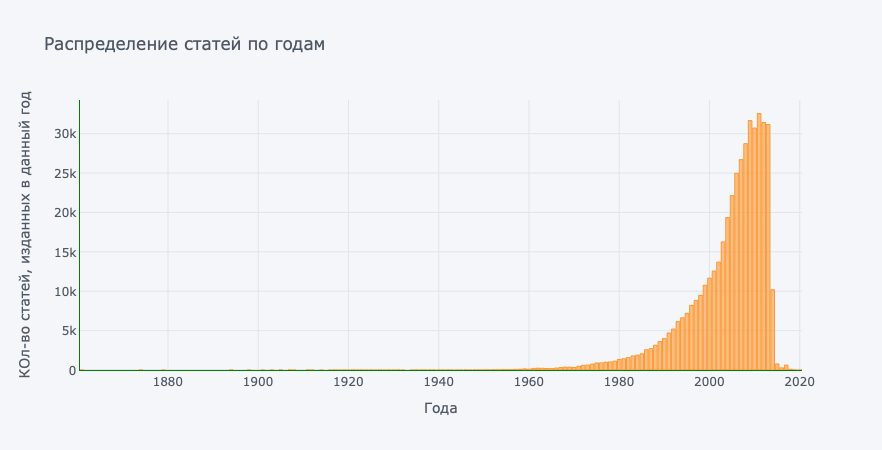

In [32]:
years[(years!=0) & (years<2023)].value_counts().iplot(kind='bar',
                     xTitle='Года',
                     linecolor='green',
                     yTitle='КОл-во статей, изданных в данный год',
                     title='Распределение статей по годам')

#### Почему график начинается с 1880? Может, есть выбросы? + Старые статьи скорее всего не особо актуальны (условно можно выкинуть статьи до 1960 года)

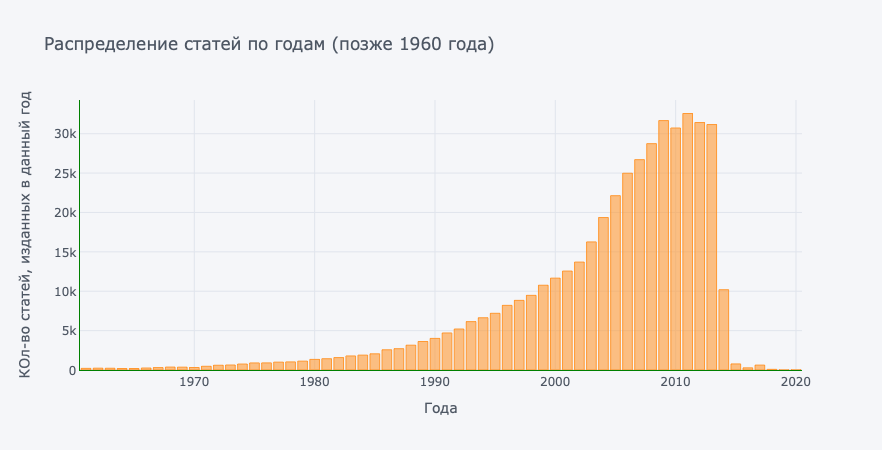

In [33]:
years[(years > 1960) & (years<2023)].value_counts().iplot(kind='bar',
                     xTitle='Года',
                     linecolor='green',
                     yTitle='КОл-во статей, изданных в данный год',
                     title='Распределение статей по годам (позже 1960 года)')

#### Пик пришелся на 2011 год
#### Посмотрим, статьи на какие темы публиковали в этом году:

In [34]:
tmp = df[['fos', 'year']].dropna()
tmp = tmp.explode('fos')
Counter(tmp[tmp['year']==2011].fos.values).most_common(30)

[('Computer science', 17907),
 ('Mathematics', 5848),
 ('Artificial intelligence', 5399),
 ('Engineering', 2153),
 ('Algorithm', 2118),
 ('Computer network', 2018),
 ('Computer vision', 1887),
 ('Mathematical optimization', 1566),
 ('Pattern recognition', 1494),
 ('Distributed computing', 1476),
 ('Data mining', 1433),
 ('Discrete mathematics', 1373),
 ('Theoretical computer science', 1359),
 ('Control theory', 1278),
 ('Machine learning', 1244),
 ('World Wide Web', 1239),
 ('Combinatorics', 1112),
 ('Computer security', 1092),
 ('Knowledge management', 1020),
 ('Electronic engineering', 964),
 ('Multimedia', 910),
 ('Software', 896),
 ('Information retrieval', 838),
 ('Human–computer interaction', 815),
 ('Real-time computing', 747),
 ('The Internet', 742),
 ('Communication channel', 645),
 ('Simulation', 644),
 ('Natural language processing', 641),
 ('Embedded system', 640)]

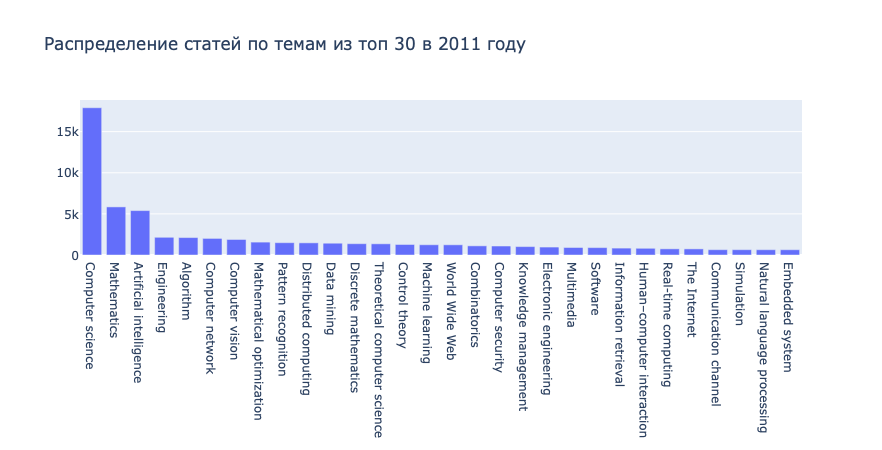

In [35]:
fos = [i[0] for i in Counter(tmp[tmp['year']==2011].fos.values).most_common(30)]
count = [i[1] for i in Counter(tmp[tmp['year']==2011].fos.values).most_common(30)]
data = [go.Bar(
   x = fos,
   y = count
)]
layout = go.Layout({"title":"Распределение статей по темам из топ 30 в 2011 году"})
fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Fos - темы статей

In [36]:
fos = df[~df.fos.isna()].fos
fos

6         [Computer science, Medical record, Medical eme...
18        [Ontology (information science), Small and med...
19        [Architecture, Knowledge level, Open Grid Serv...
20        [Grid computing, Knowledge assessment, Adaptiv...
21        [Technology development, Convergence (routing)...
                                ...                        
449995    [Object detection, Image alignment, Computer v...
449996    [Wireless network, Broadcasting, Approximation...
449997    [Computer architecture, Architecture, Open pla...
449998    [Spatial analysis, Computer vision, Output dev...
449999    [Data mining, Joins, Computer science, Algorit...
Name: fos, Length: 414321, dtype: object

In [37]:
fos_list = [item for sublist in fos.tolist() for item in sublist]
fos_list[:10]

['Computer science',
 'Medical record',
 'Medical emergency',
 'Ontology (information science)',
 'Small and medium-sized enterprises',
 'Metadata',
 'Computer science',
 'Knowledge management',
 'Upgrade',
 'Curriculum']

In [38]:
fos_dict = Counter(fos_list)
len(fos_dict)

85836

#### Всего 865863 тем статей

In [39]:
Counter(fos_dict).most_common(50)

[('Computer science', 251151),
 ('Mathematics', 88246),
 ('Artificial intelligence', 72775),
 ('Algorithm', 33884),
 ('Discrete mathematics', 26093),
 ('Engineering', 25529),
 ('Computer vision', 24483),
 ('Computer network', 24006),
 ('Combinatorics', 21740),
 ('Theoretical computer science', 21310),
 ('Distributed computing', 19552),
 ('Mathematical optimization', 18746),
 ('Pattern recognition', 17298),
 ('World Wide Web', 16133),
 ('Programming language', 15875),
 ('Data mining', 15757),
 ('Control theory', 15274),
 ('Machine learning', 13493),
 ('Multimedia', 11816),
 ('Software engineering', 11686),
 ('Knowledge management', 11651),
 ('Computer security', 11489),
 ('Electronic engineering', 11335),
 ('Information retrieval', 11302),
 ('Human–computer interaction', 10902),
 ('Software', 10876),
 ('Natural language processing', 9828),
 ('Parallel computing', 9814),
 ('The Internet', 9607),
 ('Speech recognition', 9229),
 ('Real-time computing', 8674),
 ('Artificial neural network',

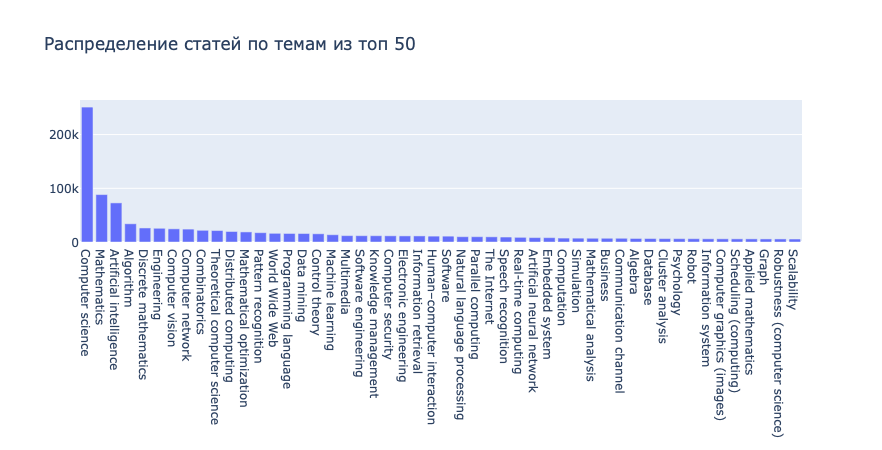

In [40]:
fos = [i[0] for i in Counter(fos_dict).most_common(50)]
count = [i[1] for i in Counter(fos_dict).most_common(50)]
data = [go.Bar(
   x = fos,
   y = count
)]
layout = go.Layout({"title":"Распределение статей по темам из топ 50"})
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### Среди технических тем появилась психология - около 6000

In [41]:
# TODO Посмотреть топ организаций, авторов и можно распределение по годам (либо в какой-то год)
df[['authors', 'abstract']].loc[99997].authors

"[{'_id': '53f49292dabfaeb15b77b5c2', 'name': 'Guoyan Zheng', 'org': 'MEM Research Center, University of Bern, Bern, Switzerland', 'email': 'Guoyan.Zheng@MEMcenter.unibe.ch', 'gid': '5b86a6fae1cd8e14a3e0d6f7', 'orgid': '5f71b2d61c455f439fe3e9d5'}, {'_id': '544084c1dabfae805a6ca4fc', 'name': 'Xuan Zhang', 'org': 'MEM Research Center, University of Bern, Bern, Switzerland', 'gid': '5b86a6fae1cd8e14a3e0d6f7', 'orgid': '5f71b2d61c455f439fe3e9d5'}, {'_id': '53f430d2dabfaee1c0a5fbfa', 'name': 'Slavica Jonić', 'org': 'Biomedical Imaging Group, École polytechnique fédérale de Lausanne (EPFL), Lausanne VD, Switzerland', 'orcid': '0000-0001-5112-2743', 'gid': '5b86cf3de1cd8e14a3fd7ccc', 'orgid': '5f71b29a1c455f439fe3d019'}, {'_id': '53f42f4cdabfaee1c0a4c545', 'name': 'Philippe Thévenaz', 'org': 'Biomedical Imaging Group, École polytechnique fédérale de Lausanne (EPFL), Lausanne VD, Switzerland', 'gid': '5b86cf3de1cd8e14a3fd7ccc', 'orgid': '5f71b29a1c455f439fe3d019'}, {'_id': '548669bfdabfaed7b5f

## Посмотрим на облако слов, составленное из текстов абстрактов.

Чем больше слова на изображении, тем чаще они используются.

In [42]:
abstract = df.loc[~df['abstract'].isna(), 'abstract'].astype(str).replace('[.,!?-]', '', regex=True)
abstract = abstract.sample(10000)
all_abstracts = ' '.join(abstract.to_list()).lower().strip()

In [43]:
%matplotlib inline
wordcloud = WordCloud(background_color="white").generate(all_abstracts)
plt.figure(figsize=(10, 10))
plt.title("Облако слов из abstract")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

KeyboardInterrupt: 

## Распределение статей по языкам

In [44]:
langs = df[~df.lang.isna()].lang.value_counts()
langs

en    449737
zh        35
Name: lang, dtype: int64

In [45]:
list(langs.values)

[449737, 35]

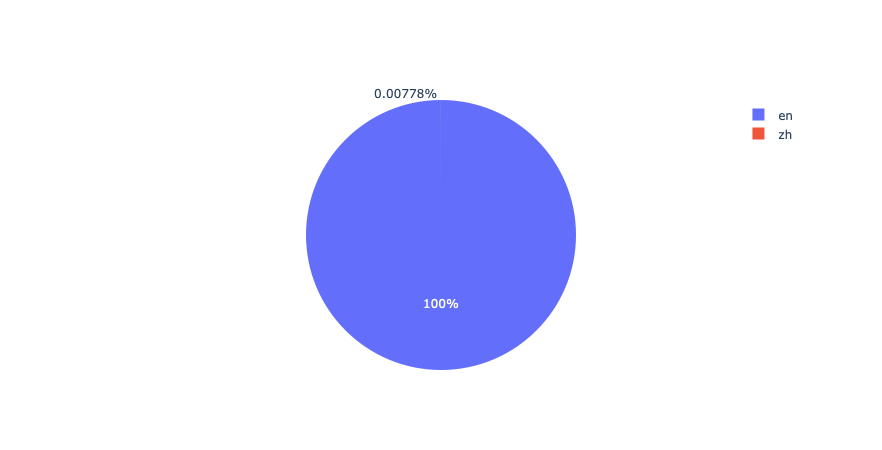

In [46]:
data = [go.Pie(labels = list(langs.index), values = list(langs.values))]
fig = go.Figure(data = data)
iplot(fig)

#### Практически 100% статей на английском языке

#### Посмотрим распределение по авторам:

In [47]:
authors = df['authors']
res = defaultdict(int)
for idx in range(len(authors) - 1):
    try:
        str_ = authors[idx].split('}')
    except KeyError:
        continue
    if '_id\':' not in authors[idx]:
        continue
    str_ = authors[idx].replace('\'', '').replace('[', '').replace(']', '').replace('{', '').replace(' ', '').split('},')
    #print(str_)
    for row in str_:
        info_arr = row.split(',')
        for note in info_arr:
            if '_id:' in note:
                res[note[4:]] += 1
                continue

In [48]:
auth_data = pd.DataFrame(dict(res).items(), columns=['person_idx', 'num_artircles'])

In [49]:
sub_sample_size = 100000  #Какое количесво берем в расчет для оценки вида функции распределения
auth_data = auth_data[:sub_sample_size]
auth_data.head(15)

,person_idx,num_artircles
0,53f47915dabfaefedbbb728f,9
1,53f44a27dabfaedf435dbf2e,19
2,5433f551dabfaebba5832602,23
3,53f322dddabfae9a84460560,8
4,53f556b9dabfaea7cd1d5e32,21
5,53f4469bdabfaedd74def186,1
6,54054904dabfae450f3a0838},1
7,5406cb05dabfae44f085c48f},1
8,53f43a76dabfaee2a1d0d548,3
9,548606a4dabfaed7b5fa26c6,12


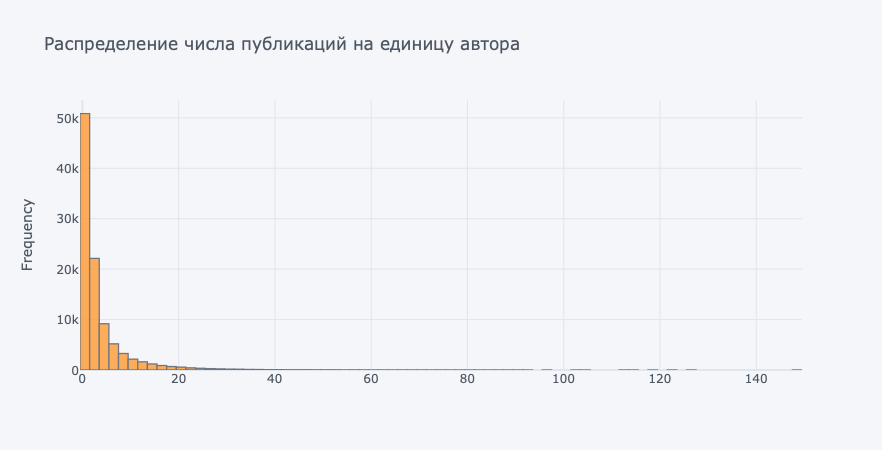

In [50]:
auth_data['num_artircles'].iplot(kind='hist',
                                 bins=140,
                                 yTitle='Frequency',
                                 title='Распределение числа публикаций на единицу автора')

Большинство авторов (с уникальным id) опубликовало от 1 до 5 статей, в этом диапазоне эта статистика экспоненцивально убывает, далее - практически по линейному закону.

### Корреляция между числом соавторов и количеством цитирований статьи¶

In [51]:
auth_ref_data = df[['authors', 'references']]
auth_ref_data = auth_ref_data[~df.references.isna()]

In [52]:
auth_ref = {}
for authors, references in zip(auth_ref_data['authors'], auth_ref_data['references']):
    auth_ref[len(authors.split('}'))] = len(references)

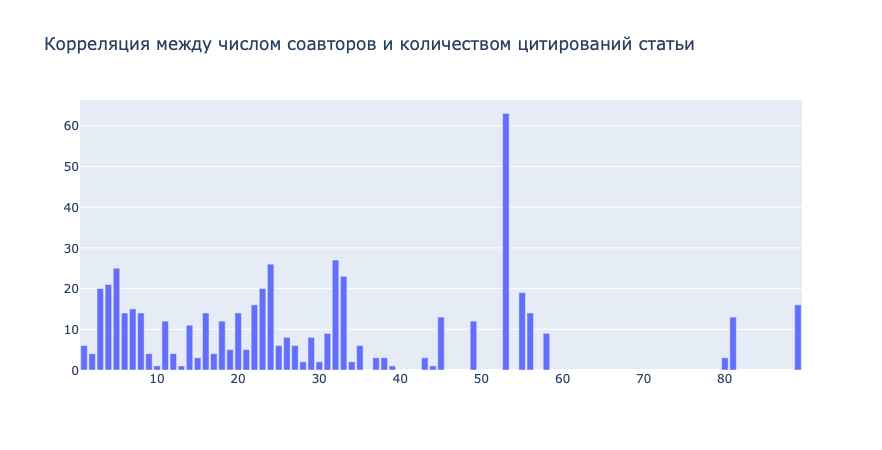

In [53]:
ref = list(auth_ref.keys())
count = list(auth_ref.values())
data = [go.Bar(
   x = ref,
   y = count
)]
layout = go.Layout({"title":"Корреляция между числом соавторов и количеством цитирований статьи"})
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Можно сделать вывод о том, что число соавторов статьи никак не определяет ее вероятную цитируемость. Однако мы видим, что в данных есть записи, где есть 80 и больше соавторов. Тут же могут иметь место элементы синтетики и ошибок при составлении базы.

# Вычислим индекс Хирша.
Учёный имеет индекс h, если h из его $N_p$ статей цитируются как минимум h раз каждая, в то время как оставшиеся ($N_p$ — h) статей цитируются не более чем h раз каждая.

In [54]:
auth_ref_data = df[['_id', 'authors', 'references']]
auth_ref_data = auth_ref_data[~df.references.isna()]
auth_ref_data.head()

,_id,authors,references
19,53a7290120f7420be8bc1497,"[{'name': 'Kazys Baniulis', '_id': '53f45307da...","[53a7290120f7420be8bc149b, 53e9b6d1b7602d97042..."
20,53a7290120f7420be8bc149b,"[{'name': 'Luca Stefanutti', '_id': '53f45af4d...","[53e998f0b7602d970212b0f0, 53e9b4f9b7602d97040..."
21,53a7290120f7420be8bc149e,"[{'name': 'Ian T. Foster', '_id': '53f48850dab...","[53e9aa3ab7602d97033a475d, 53e9b9adb7602d97045..."
22,53a7290120f7420be8bc149f,"[{'name': 'Andrea Bagnasco', '_id': '53f461b2d...","[558aad9ee4b031bae1f90867, 53e9af53b7602d97039..."
23,53a7290120f7420be8bc14ac,"[{'name': 'Vytautas Reklaitis', '_id': '53f432...","[53e9b8e8b7602d97044c8292, 53e9aadfb7602d97034..."


In [55]:
auth_ref_data['references_count'] = auth_ref_data['references'].map(lambda x: len(x))
auth_ref_data['authors'] = auth_ref_data['authors'].str.replace(', None', '')
splited_authors = []
for i, row in auth_ref_data.sample(1000).iterrows():
    # поскольку в каждой строке string c массивом, его можно исполнить и получить list
    
    # Бывает такое:
    # [{'_id': '53f7a58cdabfae92b40d1e42', 'name': 'Benjamin Kuipers'},
    # {'_id': '53f42d2fdabfaedce54c259e', 'name': 'Karl Åström'}, None]
    # поэтому надо удалять ', None'

    try:
        splited_article = pd.DataFrame(eval(row['authors']))
    except Exception as err:
        print(err)
        print(row['authors'])
        continue
        
    splited_article['references_count'] = row['references_count']
    splited_article['_id_article'] = row['_id']
    splited_authors.append(splited_article)
splited_authors = pd.concat(splited_authors, axis=0)
splited_authors

,_id,name,org,orgs,email,orcid,orgid,references_count,_id_article,gid,oid,bio,sid,org_zh,orgs_zh
0,53f443eadabfaeb22f4b594b,Ruchi Mittal,"NSIT, Dept Comp Sci, New Delhi, India","[NSIT, Dept Comp Sci, New Delhi, India]",ruchi.mittal138@gmail.com,0000-0001-6818-2355,5f71b6051c455f439fe5501d,1,53e99aa5b7602d970231ae9c,NaN,NaN,NaN,NaN,NaN,NaN
1,53f432fbdabfaeb2ac03070b,Ipsita Bhattacharya,"NSIT, Dept Comp Sci, New Delhi, India","[NSIT, Dept Comp Sci, New Delhi, India]",NaN,NaN,5f71b6051c455f439fe5501d,1,53e99aa5b7602d970231ae9c,NaN,NaN,NaN,NaN,NaN,NaN
2,53f3227adabfae9a8445e2c3,M. P. S. Bhatia,"NSIT, Dept Comp Sci, New Delhi, India","[NSIT, Dept Comp Sci, New Delhi, India]",NaN,NaN,5f71b6051c455f439fe5501d,1,53e99aa5b7602d970231ae9c,NaN,NaN,NaN,NaN,NaN,NaN
0,53f4375ddabfaee43ec38aa4,Urban Maeder,Corresponding author. Tel.: +41 44 632 55 37; ...,[Corresponding author. Tel.: +41 44 632 55 37;...,maeder@control.ee.ethz.ch,NaN,NaN,4,53e99b4ab7602d97023ec461,NaN,NaN,NaN,NaN,NaN,NaN
1,53f4354edabfaedce552591c,Manfred Morari,"Automatic Control Lab, ETH Zurich, CH-8092, Zu...","[Automatic Control Lab, ETH Zurich, CH-8092, Z...",morari@control.ee.ethz.ch,NaN,5f71b2911c455f439fe3cc40,4,53e99b4ab7602d97023ec461,5b868a22e1cd8e14a323c5f1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,53f43c1edabfaeb1a7c12885,Shoji Tatsumi,NaN,NaN,NaN,NaN,NaN,14,53e99d1ab7602d97025cbe4f,NaN,NaN,NaN,NaN,NaN,NaN
0,562d555345cedb3398dcb766,Hafedh Mili,NaN,NaN,NaN,NaN,NaN,9,53e99b77b7602d970241dcf1,NaN,NaN,NaN,NaN,NaN,NaN
0,53f436efdabfaeb1a7bf8ab2,Rebecca Braynard,"Department of Computer Science, Duke Universit...",NaN,rebecca@cs.duke.edu,NaN,5f71b2861c455f439fe3c7a1,14,53e99b43b7602d97023e6b88,5b86b6dde1cd8e14a34d6eff,NaN,NaN,NaN,NaN,NaN
1,53f42debdabfaedd74d3da03,Adam Silberstein,"Department of Computer Science, Duke Universit...",NaN,adam@cs.duke.edu,NaN,5f71b2861c455f439fe3c7a1,14,53e99b43b7602d97023e6b88,5b86b6dde1cd8e14a34d6eff,NaN,NaN,NaN,NaN,NaN


In [57]:
splited_authors.groupby(['_id', 'references_count']).agg({'_id_article': 'count'})

,,_id_article
_id,references_count,
53f319f2dabfae9a8442ea67,11,1
53f31a49dabfae9a84430a05,14,1
53f31a6adabfae9a84431450,69,1
53f31bf6dabfae9a84439dee,4,1
53f31bf6dabfae9a84439e22,10,1
...,...,...
56cb1890c35f4f3c65650fdf,9,1
56cb189cc35f4f3c65655686,8,1
56cb18acc35f4f3c6565a9a7,7,1


In [77]:
authors_ref_stats = splited_authors.sort_values(by='references_count', ascending=False).groupby('_id').agg(
    {'references_count' : list, '_id_article': 'count'})
authors_ref_stats.sort_values(by='_id_article', ascending=False).rename({'_id_article': 'article_count'}, axis='columns')

,references_count,article_count
_id,,
5405b74cdabfae450f3c967f,"[13, 6]",2
54093fb6dabfae450f46f763,"[31, 15]",2
53f45715dabfaedf4360e214,"[8, 8]",2
53f46159dabfaee02ad800fb,"[11, 2]",2
53f7d1d0dabfae9060aece60,"[31, 1]",2
...,...,...
53f439aadabfaee43ec4e5b5,[19],1
53f439acdabfaeee229c97eb,[7],1
53f439addabfaedce554d702,[24],1


In [78]:
def count_h_index(array):
    for idx, ref_count in enumerate(array):
        if ref_count < idx + 1:
            return idx
    return idx + 1

assert count_h_index([13, 12, 11]) == 3
assert count_h_index([45, 2, 1]) == 2
assert count_h_index([1, 1, 1, 1]) == 1
print('ok')

ok


Мы написали функция для вычисления индекса Хирша и применили ее к массиву из числа цитирований каждой статьи автора.

In [81]:
authors_ref_stats['h_index'] = authors_ref_stats['references_count'].map(count_h_index)
authors_ref_stats.sort_values(by='h_index', ascending=False)

,references_count,_id_article,h_index
_id,,,
5405fad4dabfae91d3023504,"[32, 13]",2,2
5487bcb6dabfaed7b5fa32a1,"[16, 10]",2,2
53f4d301dabfaeedd2780b42,"[8, 3]",2,2
54093fb6dabfae450f46f763,"[31, 15]",2,2
53f4bba1dabfaeda9977b50c,"[18, 4]",2,2
...,...,...,...
53f4399fdabfaedd74dbe803,[8],1,1
53f439a1dabfaeee229c90b6,[26],1,1
53f439aadabfaee43ec4e5b5,[19],1,1


In [ ]:
authors_ref_stats